<a href="https://colab.research.google.com/github/JeremyTo04/Final-Year-Project/blob/main/Diffae_FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!git clone https://github.com/phizaz/diffae
%cd diffae
!git pull https://github.com/phizaz/diffae


Cloning into 'diffae'...
remote: Enumerating objects: 490, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 490 (delta 88), reused 81 (delta 78), pack-reused 374 (from 1)
Receiving objects: 100% (490/490), 11.23 MiB | 16.86 MiB/s, done.
Resolving deltas: 100% (279/279), done.
/content/diffae
From https://github.com/phizaz/diffae
 * branch            HEAD       -> FETCH_HEAD
Already up to date.


In [7]:
# import statements
!pip install pytorch_lightning
!pip install lmdb==1.2.1
!pip install pytorch-fid==0.2.0
!pip install lpips==0.1.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.5/881.5 kB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lmdb: filename=lmdb-1.2.1-cp310-cp310-linux_x86_64.whl size=265651 sha256=ffc9bf42cf392626a43e3e693ac202065c1b257cea196086573ca7b01134f716
  Stored in directory: /root/.cache/pip/wheels/ae/36/fc/13e586283759d30c3efc3d0b917b2c5f1b69d171de8b7ed204
Successfully built lmdb
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-fid: filename=pytorch_fid-0.2.0-py3-none-any.whl size=10524 sha256=17c5c705717da61a3fb03f2cb35cc487877ad6fab1ebca8a7b5aed6ad1f20015
  Stored in directory: /root/.cache/pip/wheels/3b/71/5b/541560613ec27b54ce8aa2bd34a1d8415a90e78ac0c1732103
Successfully built pytorch-fid
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.3 MB/s eta 0:00:00


In [8]:
from templates import *

In [9]:
#@markdown <h3> ⚙️ Model Configuration</h3>
#@markdown <small> we have provided 128 and 256 pretrained models; you may train our model with your own preference (checkout our github repository) .</small> <br>
#@markdown <small> T_step:  is the number of step for generation in DiffAE. </small> <br>

device = 'cuda:0'
model_resolution = 256 #@param [128, 256]
T_inv = 200 #@param [50,100,125,200,250,500]
T_step = 100 #@param [50,100,125,200,250,500]

model_config = ffhq256_autoenc() if model_resolution == 256 else  ffhq128_autoenc_130M()

print(model_config.name)


# download model weight & its inferenced latents

ffhq256_autoenc


In [10]:
#@markdown <h3> 📥  Download pretrained weights </h3>

import os.path as osp

download_paths = {
    256: {
        'diffae_weight': 'https://vistec-my.sharepoint.com/:u:/g/personal/nattanatc_pro_vistec_ac_th/ER56kn-uzlNAi39E1c784qQBkj5RI7-OAZC9QghQsIDQiQ?download=1' ,
        'diffae_latent':  'https://vistec-my.sharepoint.com/:u:/g/personal/nattanatc_pro_vistec_ac_th/EcZqHAWy2v9GuaXuESDg1tUB4li-hf0aC-2SjeLxB3ASdQ?download=1' ,
        'cls_weight': 'https://vistec-my.sharepoint.com/:u:/g/personal/nattanatc_pro_vistec_ac_th/ESzwEubKDNBEmYcbEr9O2jABtNqk_p7f2xYQ_t3PurXnHg?download=1'
    },
    128: {
        'diffae_weight': 'https://vistec-my.sharepoint.com/:u:/g/personal/nattanatc_pro_vistec_ac_th/Eb36o-4NlSFGmpj3Vut2p-gBswf8PsUmeiqIEbA8XmAqWA?download=1',
        'diffae_latent': 'https://vistec-my.sharepoint.com/:u:/g/personal/nattanatc_pro_vistec_ac_th/EQ9jjIjJRcJCs6h3d_LnJYoBvKk7zEMlHZn5btEKBEYoXg?download=1',
        'cls_weight': 'https://vistec-my.sharepoint.com/:u:/g/personal/nattanatc_pro_vistec_ac_th/Eb36o-4NlSFGmpj3Vut2p-gBswf8PsUmeiqIEbA8XmAqWA?download=1'
    }
}

weight_dir_path = f'checkpoints/{model_config.name}'
if not osp.exists(weight_dir_path): os.makedirs(weight_dir_path)
model_download_path = download_paths[model_resolution]['diffae_weight']
latents_download_path = download_paths[model_resolution]['diffae_latent']
!wget -O '{weight_dir_path}/last.ckpt' '{model_download_path}'
!wget -O '{weight_dir_path}/latent.pkl' '{latents_download_path}'

from templates_cls import ffhq256_autoenc_cls, ffhq128_autoenc_130M

classifer_config = ffhq256_autoenc_cls() if model_resolution == 256 else ffhq128_autoenc_130M()
weight_dir_path = f'checkpoints/{classifer_config.name}'
if not osp.exists(weight_dir_path): os.makedirs(weight_dir_path)
cls_download_path = download_paths[model_resolution]['cls_weight']
!wget -O '{weight_dir_path}/last.ckpt' '{cls_download_path}'

--2024-09-06 15:07:30--  https://vistec-my.sharepoint.com/:u:/g/personal/nattanatc_pro_vistec_ac_th/ER56kn-uzlNAi39E1c784qQBkj5RI7-OAZC9QghQsIDQiQ?download=1
Resolving vistec-my.sharepoint.com (vistec-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to vistec-my.sharepoint.com (vistec-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/nattanatc_pro_vistec_ac_th/Documents/diffae-public/checkpoints/ffhq256_autoenc/last.ckpt?ga=1 [following]
--2024-09-06 15:07:30--  https://vistec-my.sharepoint.com/personal/nattanatc_pro_vistec_ac_th/Documents/diffae-public/checkpoints/ffhq256_autoenc/last.ckpt?ga=1
Reusing existing connection to vistec-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 2722085968 (2.5G) [application/octet-stream]
Saving to: ‘checkpoints/ffhq256_autoenc/last.ckpt’

checkpoints/ffhq256 100%[===================>]   2.53G  65.8MB/s    in 65s  

In [12]:
#@markdown <h3> ⚡ Model Initialization </h3>
from experiment import LitModel
model = LitModel(model_config)
state = torch.load(f'checkpoints/{model_config.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

INFO:lightning_fabric.utilities.seed:Seed set to 0


Model params: 160.69 M


<ipython-input-12-32d36b604c6e>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f'checkpoints/{model_config.name}/last.ckpt', map_location='cpu')


In [1]:
# !nvcc --version
# import torch
# print("CUDA Available:", torch.cuda.is_available())  # Should return True
# print("CUDA Device Name:", torch.cuda.get_device_name(0))  # Should print the name of the CUDA device
# print("PyTorch CUDA Version:", torch.version.cuda)  # Should print the CUDA version PyTorch is using


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
CUDA Available: True
CUDA Device Name: Tesla T4
PyTorch CUDA Version: 12.1


In [14]:
#@markdown <h3>  🐶 😸  Classifier Initialization  </h3>
from experiment_classifier import ClsModel

classifier_config = ffhq256_autoenc_cls() if model_resolution == 256 else ffhq128_autoenc_cls()
classifier_config.pretrain = None # a bit faster
classifier = ClsModel(classifier_config)
state = torch.load(f'checkpoints/{classifer_config.name}/last.ckpt', map_location='cpu')
print('latent step:', state['global_step'])
classifier.load_state_dict(state['state_dict'], strict=False)
classifier.to(device);


INFO:lightning_fabric.utilities.seed:Seed set to 0


loading latent stats ...
latent step: 9375


/content/diffae/experiment_classifier.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(conf.latent_infer_path)
<ipython-input-14-3c527ebd8725>:7: Futu

In [ ]:
# import os

# def remove_uploaded_img(image_name):
#     img_path = os.path.join(uploaded_imgs_path, image_name)

#     if os.path.exists(img_path):
#         os.remove(img_path)
#         print(f"Image {image_name} removed successfully.")
#     else:
#         print(f"Image {image_name} does not exist.")

# # Example: Remove an uploaded image by name
# remove_uploaded_img('your_image_name.jpg')


Saving Frame_000004571.jpg to Frame_000004571.jpg


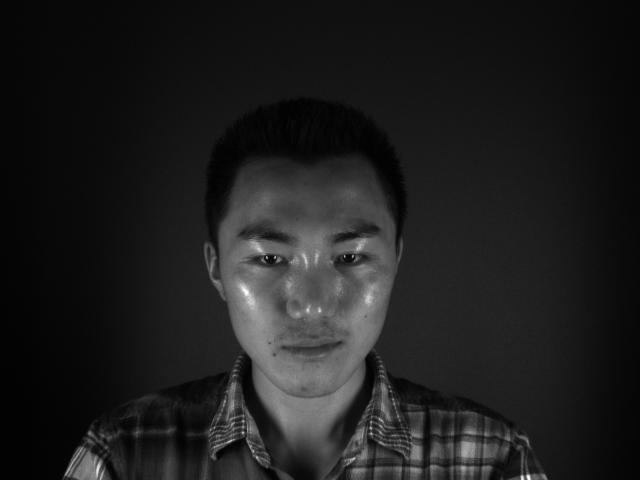

move file Frame_000004571.jpg to uploaded_imgs 


In [77]:
#@markdown <h3> 📤  Upload an image 👨 👩    for manipulation </h3>


from google.colab import files
import cv2
from google.colab.patches import cv2_imshow
import shutil


uploaded_imgs_path = 'uploaded_imgs'
if not osp.exists(uploaded_imgs_path) : os.makedirs(uploaded_imgs_path)

def upload_img():
  uploaded_img = files.upload()
  uploadded_img_name = list(uploaded_img.keys())[0]

  img = cv2.imread(uploadded_img_name)
  cv2_imshow(img)

  # shutil.move(uploadded_img_name, uploaded_imgs_path)
  !mv "{uploadded_img_name}" "{uploaded_imgs_path}"

  print(f"move file {uploadded_img_name} to {uploaded_imgs_path} ")
# print(uploaded_img.keys())
# for fn in uploaded_img.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded_img[fn])))

upload_img()

cached
cached
total img files 2
100% 2/2 [00:01<00:00,  1.27it/s]
output aligned images at: aligned_uploaded_imgs


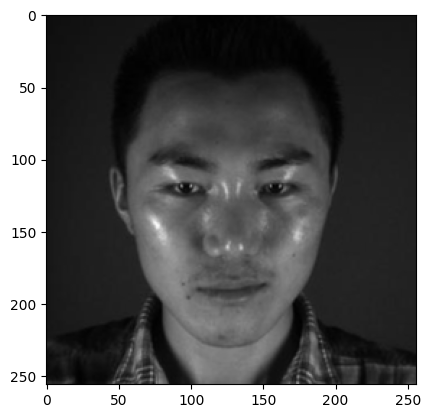

In [79]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from dataset import ImageDataset

def convert2rgb(img, adjust_scale=True):
    # Convert to tensor if not already
    if not isinstance(img, torch.Tensor):
        img = torch.tensor(img)

    # Adjust scale if needed
    if adjust_scale:
        img = (img + 1) / 2  # Ensure the image values are in [0, 1]

    # Convert to NumPy array
    img_np = img.cpu().numpy()

    # Ensure the image is in float range [0, 1] or integer [0, 255]
    if img_np.max() > 1:
        img_np = img_np / 255.0  # Normalize to [0, 1] if values are in [0, 255]

    # Transpose from (c, h, w) to (h, w, c)
    img_np = np.transpose(img_np, (1, 2, 0))

    return img_np

# Pre-process the uploaded image
uploaded_imgs_path = 'uploaded_imgs'
aligned_uploaded_imgs_path = 'aligned_uploaded_imgs'
if not osp.exists(aligned_uploaded_imgs_path):
    os.makedirs(aligned_uploaded_imgs_path)

!python align.py -i 'uploaded_imgs' -o 'aligned_uploaded_imgs'

imgdataset_path = aligned_uploaded_imgs_path  # path to image dataset
data = ImageDataset(imgdataset_path, image_size=model_config.img_size, exts=['jpg','jpeg', 'JPG', 'png'], do_augment=False)

# Load the image and convert
img = data[1]['img']
img_rgb = convert2rgb(img)

# Display the image
plt.imshow(img_rgb)
# plt.axis('off')  # Optionally turn off axis
plt.show()


In [84]:
#@markdown <h3>  👶  🔁  👨 🔁  👴  Encode and Manipulate the uploaded image </h3>
#@markdown <h5> manipulation amplitude: The Strongness of Manipulation <h5/>.
# too strong would be resulted in artifact as it could dominate the original image information </small>

from dataset import CelebAttrDataset
import math
import torch.nn.functional as F

target_class = 'Bangs' #@param ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
manipulation_amplitude = 0.15 #@param {{type:"slider", min:-0.5, max:0.5, step:0.05}

# reverse the amplitude for some classes that are trained with opposite labels
cls_manipulation_amplitude = manipulation_amplitude
interpreted_target_class = target_class
if target_class not in CelebAttrDataset.id_to_cls and f'No_{target_class}' in CelebAttrDataset.id_to_cls:
  cls_manipulation_amplitude = -manipulation_amplitude
  interpreted_target_class = f'No_{target_class}'



batch = data[1]['img'][None]

semantic_latent = model.encode(batch.to(device))
stochastic_latent = model.encode_stochastic(batch.to(device), semantic_latent, T=T_inv)




cls_id = CelebAttrDataset.cls_to_id[interpreted_target_class]
class_direction = classifier.classifier.weight[cls_id]
normalized_class_direction = F.normalize(class_direction[None, :], dim=1)

normalized_semantic_latent = classifier.normalize(semantic_latent)
normalized_manipulation_amp = cls_manipulation_amplitude * math.sqrt(512)
normalized_manipulated_semantic_latent =  normalized_semantic_latent + normalized_manipulation_amp*normalized_class_direction

manipulated_semantic_latent = classifier.denormalize(normalized_manipulated_semantic_latent)

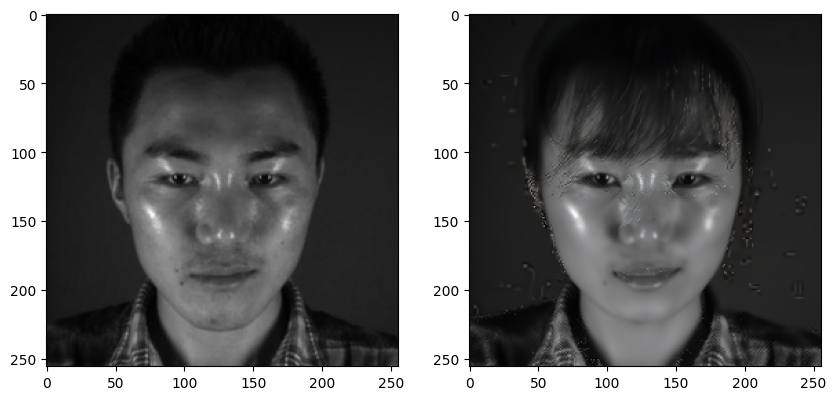

In [83]:
#@markdown <h3> 😎 Render Manipulated image </h3>


manipulated_img = model.render(stochastic_latent, manipulated_semantic_latent, T=T_step)[0]
original_img = data[1]['img']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(convert2rgb(original_img))
ax[1].imshow(convert2rgb(manipulated_img,adjust_scale=False))
# plt.savefig('imgs_manipulated/compare.png')